# GAN creation

In [ ]:
# For COLAB
from google.colab import drive
drive.mount('/content/gdrive')
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download xhlulu/140k-real-and-fake-faces
! unzip /content/140k-real-and-fake-faces.zip
# ! pip install matplotlib

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [16]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 5108843273256352239
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1745302324
locality {
  bus_id: 1
  links {
  }
}
incarnation: 731205508174102857
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [17]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Dataset loading

In [18]:
from keras.preprocessing.image import ImageDataGenerator

In [19]:
BATCH_SIZE = 128
image_height = 64
image_width = 64
latent_features = 100
num_images = 5000

In [20]:
# Define the input and output directories
input_directory = 'real_vs_fake/real-vs-fake/test/'

# Create a dataset from the images
real_folder = os.path.join(input_directory, 'real')
image_paths = [os.path.join(real_folder, filename) for filename in os.listdir(real_folder)[:num_images]]

# Function to preprocess the image
def preprocess_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [image_height, image_width])
    img = tf.cast(img, tf.float32)
    img = (img - 127.5) / 127.5
    return img

# Create a dataset from the image paths
dataset = tf.data.Dataset.from_tensor_slices(image_paths)
dataset = dataset.map(preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(BATCH_SIZE)

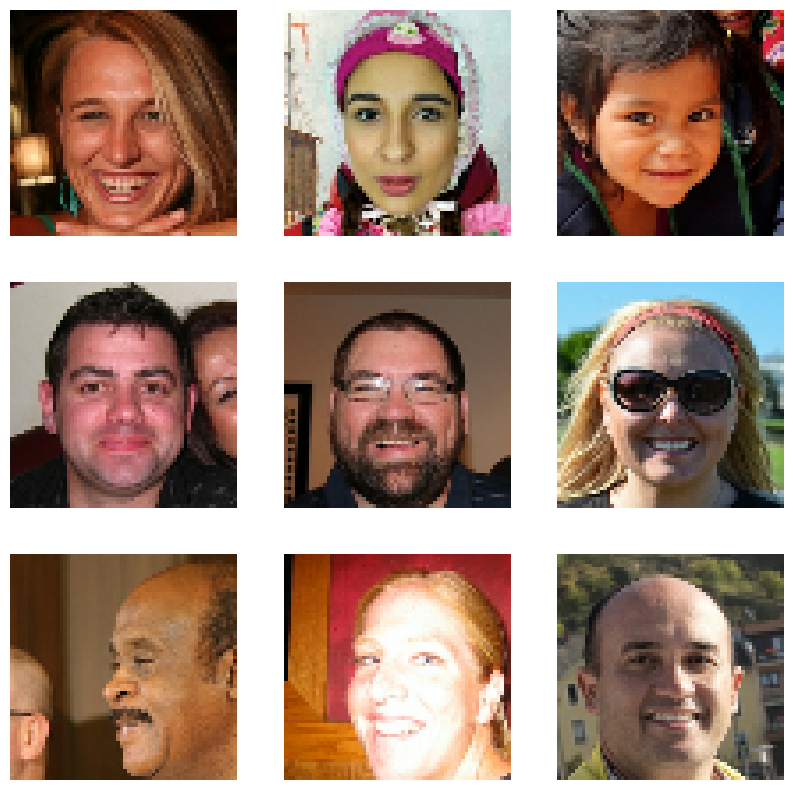

In [21]:
for batch in dataset.take(1):  # Take the first batch for display
    batch = (batch + 1) / 2
    plt.figure(figsize=(10, 10))
    for i in range(min(BATCH_SIZE, 9)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(batch[i].numpy())
        plt.axis("off")
    plt.show()

In [22]:
len(dataset)

40

## GAN architecture

In [23]:
from keras.initializers import RandomNormal
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, Conv2DTranspose, BatchNormalization, ZeroPadding2D, UpSampling2D, Activation

In [12]:
def build_generator():
    init = RandomNormal(stddev=0.02, seed=69)
    model = Sequential()

    model.add(Dense(4*4*512, input_dim=latent_features, kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Reshape((4,4,512)))

    model.add(Conv2DTranspose(256, 5, 2,padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(128, 5, 2,padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(64, 5, 2,padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2DTranspose(32, 5, 2,padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))

    model.add(Conv2D(3, 5, 1,padding='same', activation='tanh', kernel_initializer=init))

    return model

generator = build_generator()
generator.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 8192)              827392    
                                                                 
 batch_normalization_7 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 8192)              0         
                                                                 
 reshape_1 (Reshape)         (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 8, 8, 256)        3277056   
 ranspose)                                                       
                                                                 
 batch_normalization_8 (Batc  (None, 8, 8, 256)       

In [ ]:
img = generator.predict(np.random.normal(size=(1, latent_features, 1)))
plt.imshow(img[0])

In [26]:
def build_discriminator():
    init = RandomNormal(stddev=0.02, seed=69)
    model = Sequential()

    model.add(Conv2D(32, 5, 2, padding='same', input_shape = (image_width,image_height,3), kernel_initializer=init))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, 5, 2, padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, 5, 2, padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(256, 5, 2, padding='same', kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Conv2D(512, 4, 1, kernel_initializer=init))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 32, 32, 32)        2432      
                                                                 
 leaky_re_lu_30 (LeakyReLU)  (None, 32, 32, 32)        0         
                                                                 
 dropout_22 (Dropout)        (None, 32, 32, 32)        0         
                                                                 
 conv2d_24 (Conv2D)          (None, 16, 16, 64)        51264     
                                                                 
 batch_normalization_26 (Bat  (None, 16, 16, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_31 (LeakyReLU)  (None, 16, 16, 64)        0         
                                                      

In [ ]:
img = generator.predict(np.random.normal(size=(4, latent_features, 1)))
discriminator.predict(img)

## Training loop

In [ ]:
# from keras.models import load_model
# generator = load_model('models\generator.h5')
# discriminator = load_model('models\discriminator.h5')

In [ ]:
from keras.models import Model
from keras.optimizers import Adam
from keras.losses import BinaryCrossentropy
from keras.utils import array_to_img
from keras.callbacks import Callback

In [ ]:
g_opt = Adam(learning_rate=0.0002,beta_1=0.5)
d_opt = Adam(learning_rate=0.0002,beta_1=0.5)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [ ]:
class GAN(Model):
    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for losses and optimizers
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        # Train the discriminator
        with tf.GradientTape() as d_tape:
            real_images = batch
            ypred_real = self.discriminator(real_images, training=True)
            y_real = tf.zeros_like(ypred_real)
            noise_real = 0.10*tf.random.uniform(tf.shape(ypred_real))
            y_real += noise_real
            real_d_loss = self.d_loss(y_real, ypred_real)

            fake_images = self.generator(tf.random.normal((BATCH_SIZE, latent_features, 1)), training=False)
            ypred_fake = self.discriminator(fake_images, training=True)
            y_fake = tf.ones_like(ypred_fake)
            noise_fake = -0.10*tf.random.uniform(tf.shape(ypred_fake))
            y_fake += noise_fake
            fake_d_loss = self.d_loss(y_fake, ypred_fake)

            total_d_loss = real_d_loss + fake_d_loss
        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            gen_images = self.generator(tf.random.normal((BATCH_SIZE,latent_features,1)), training=True)
            predicted_labels = self.discriminator(gen_images, training=False)
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)
        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

In [ ]:
gan = GAN(generator, discriminator)
gan.compile(g_opt, d_opt, g_loss, d_loss)

In [ ]:
class ModelMonitor(Callback):
    def __init__(self, latent_dim=latent_features):
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            random_latent_vectors = tf.random.uniform((1, self.latent_dim,1))
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = (generated_images + 1) / 2
            generated_images = generated_images.numpy()
            img = array_to_img(generated_images[0])
            os.makedirs("/content/training/", exist_ok=True)
            img.save(f'/content/training/{100 + epoch}_generated_img.png')
            generator.save('/content/gdrive/MyDrive/GAN_research/generator.keras')
            discriminator.save('/content/gdrive/MyDrive/GAN_research/discriminator.keras')


## Training

In [ ]:
hist = gan.fit(dataset, epochs=400, callbacks=[ModelMonitor()])

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

In [ ]:
# generator.save('models/generator.h5')
# discriminator.save('models/discriminator.h5')

## Testing

In [ ]:
img = generator.predict(tf.random.normal((1, latent_features, 1)))
img = (img + 1) / 2
plt.imshow(img[0])